In [1]:
import sys
sys.path.append('./source_code')

In [51]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import pickle
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, \
    KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, roc_curve, confusion_matrix
import xgboost as xgb
import classification_helpers as ch

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
# sns.set(color_codes=True)
custom_palette = ['#1E3231', '#485665', '#8E7C93', '#D0A5C0', '#F6C0D0']
sns.set_palette(custom_palette)
# plt.style.use('seaborn-colorblind')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)
pd.set_option('display.max_info_columns', 200)

In [3]:
with open('pickles/combined_sample_weather_df5.pickle', 'rb') as read_file:
    sample_df = pickle.load(read_file)

In [5]:
base_numerical_features = ['airline_avg_arrival_delay',
                           'origin_airport_avg_flights_per_day',
                           'origin_airport_avg_departure_delay',
                           'destination_airport_avg_flights_per_day',
                           'destination_airport_avg_arrival_delay',
                           'month_avg_delay',
                           'day_of_week_avg_delay']

weather_numerical_features = ['Precipitation_origin',
                              'Snow Depth_origin',
                              'Visibility_origin',
                              'Wind Speed_origin',                      
                              'Precipitation_destination',
                              'Snow Depth_destination',
                              'Visibility_destination',
                              'Wind Speed_destination']
                              

weather_categorical_features = ['is_Clear_origin',
                                'is_Partially cloudy_origin',
                                'is_Rain_origin',
                                'is_Snow_origin',
                                'is_Overcast_origin',
                                'is_Clear_destination',
                                'is_Partially cloudy_destination',
                                'is_Rain_destination',
                                'is_Snow_destination',
                                'is_Overcast_destination']

base_categorical_features = ['American Airlines Inc.', 'American Eagle Airlines Inc.',
                             'Atlantic Southeast Airlines', 'Delta Air Lines Inc.',
                             'Frontier Airlines Inc.', 'Hawaiian Airlines Inc.', 'JetBlue Airways',
                             'Skywest Airlines Inc.', 'Southwest Airlines Co.', 'Spirit Air Lines',
                             'US Airways Inc.', 'United Air Lines Inc.', 'Virgin America',
                             'is_thanksgiving_period', 'is_xmas_period',
                             'is_night_departure', 'is_night_arrival']

target = ['is_not_on_time']

all_features = (base_numerical_features 
                + base_categorical_features 
                + weather_numerical_features)

In [71]:
X, y = ch.feature_target_selection(all_features, target, sample_df)

X_train_val, X_test, y_train_val, y_test = ch.initial_split(X, y.values.ravel())
X_train, X_val, y_train, y_val = ch.second_split(X_train_val, y_train_val)

lm = LogisticRegression(penalty='none', max_iter=10000)
lm_balanced = LogisticRegression(penalty='none', max_iter=10000, class_weight='balanced')

rf = RandomForestClassifier()
rf_balanced = RandomForestClassifier(n_estimators=100, max_depth=6, class_weight='balanced')

In [7]:
ch.test_scores(lm_balanced, X_train_val, X_test,
               y_train_val, y_test,
               threshold=.47, scale=True)

Model name: LogisticRegression
Hyperparameters: class_weight='balanced', max_iter=10000, penalty='none'

Train F1:                                 0.40
Test F1:                                  0.39
Train precision:                          0.28
Test precision:                           0.28
Train recall:                             0.66
Test recall:                              0.65
Train accuracy:                           0.60
Test accuracy:                            0.59
Train AUC:                                0.62
Test AUC:                                 0.61

Feature coefficients:

airline_avg_arrival_delay                 0.06
origin_airport_avg_flights_per_day        0.02
origin_airport_avg_departure_delay        0.13
destination_airport_avg_flights_per_day   0.04
destination_airport_avg_arrival_delay     0.11
month_avg_delay                           0.22
day_of_week_avg_delay                     0.04
American Airlines Inc.                   -0.02
American Eagle Airlines I

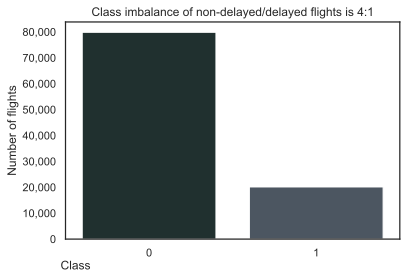

In [61]:
# Change data to 'On-time (0)' and 'Delayed (1)' 
# Change color palette
# Change ylabel and title coordinates to match Alice's 
fig, ax = plt.subplots()
# fig.set_size_inches([10, 5])

sns.countplot(x='is_not_on_time', data=sample_df)
sns.set_style("white")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set(title='Class imbalance of non-delayed/delayed flights is 4:1',
       xlabel='Class',
       ylabel='Number of flights')
ax.xaxis.set_label_coords(.03, -.1);

In [72]:
feature_names = X_train_val.columns
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
model = lm_balanced.fit(X_train_val_scaled, y_train_val)

In [73]:
coef = list(zip(feature_names, model.coef_[0]))

In [74]:
coef = sorted(coef, key=lambda x: abs(x[1]), reverse=True)

In [76]:
len(coef)

32

In [77]:
largest_coef = coef[:14]

In [79]:
largest_coef_dict = dict(largest_coef)

In [87]:
largest_coef_dict

{'is_night_arrival': 0.233442596400634,
 'month_avg_delay': 0.21568060741639536,
 'Visibility_origin': -0.1644210888573508,
 'Precipitation_destination': 0.14859258808693576,
 'Wind Speed_destination': 0.14103391772336213,
 'Precipitation_origin': 0.13156588355274487,
 'origin_airport_avg_departure_delay': 0.13026098436585498,
 'Wind Speed_origin': 0.1286880005542854,
 'Delta Air Lines Inc.': -0.12656561394380567,
 'Visibility_destination': -0.12494322441011518,
 'destination_airport_avg_arrival_delay': 0.11358121149066491,
 'Snow Depth_origin': 0.07172822092410883,
 'airline_avg_arrival_delay': 0.0644872967973431,
 'Spirit Air Lines': 0.05351428908469521}

In [98]:
pd.DataFrame(largest_coef_dict, index=range(1))

,is_night_arrival,month_avg_delay,Visibility_origin,Precipitation_destination,Wind Speed_destination,Precipitation_origin,origin_airport_avg_departure_delay,Wind Speed_origin,Delta Air Lines Inc.,Visibility_destination,destination_airport_avg_arrival_delay,Snow Depth_origin,airline_avg_arrival_delay,Spirit Air Lines
0,0.23,0.22,-0.16,0.15,0.14,0.13,0.13,0.13,-0.13,-0.12,0.11,0.07,0.06,0.05


In [90]:
largest_coef_df

,Features,Coefficients


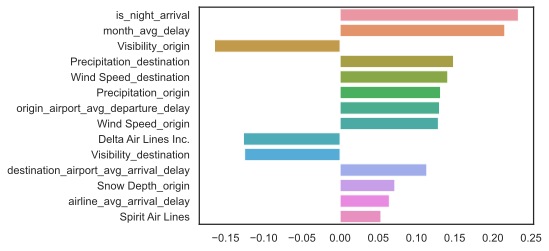

In [104]:
# Break up feature importance into categories: average delay statistics, airlines, weather 
# (and plot bar chart for each)
fig, ax = plt.subplots()

sns.barplot(x=coef_sorted, y=feature_names_sorted)

In [102]:
feature_names_sorted = []
for row in largest_coef:
    feature_names_sorted.append(row[0])

In [103]:
coef_sorted = []
for row in largest_coef:
    coef_sorted.append(row[1])